In [2]:
# 20210802 
# sarahfong

import os, sys
import pandas as pd
from scipy import stats
import subprocess

In [3]:
PATH = "/dors/capra_lab/projects/enhancer_ages/chen_2018/"

In [4]:
F = f"{PATH}chen_2018_15808_eRNA.csv"

OUTF = f"{PATH}chen_2018_15808_eRNA.bed"

In [5]:
def saveas_bed(f, outf):
    df = pd.read_csv(f)
    df.to_csv(outf, sep = '\t', index = False)
    df.columns = ["#chr_enh", "start_enh", "end_enh"]
    df["chen2018"] = 1
    
    return df

chen2018 = saveas_bed(F, OUTF)

In [6]:
FANTOMPATH = "/dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/no-exon_all_fantom_enh/breaks/"
FANTOM = f"{FANTOMPATH}no-exon_all_fantom_enh_ages_enh_age_arch_summary_matrix.bed"

def format_fantom(fantom_file):
    fdf = pd.read_csv(FANTOM, sep = '\t').drop_duplicates()
    fdf.drop(["sample_id"], axis = 1)
    fdf = fdf.loc[fdf["#chr_enh"] != "chrX"] # remove X chromosome
    return fdf

In [7]:
fdf = format_fantom(FANTOM)

In [8]:
fdf.head()

,#chr_enh,start_enh,end_enh,enh_id,sample_id,seg_index,core_remodeling,arch,mrca,taxon,mrca_2,taxon2
0,chr10,100074404,100074582,chr10:100074404-100074582,2,1,0,simple,0.175,Eutheria,0.175,Eutheria (105)
1,chr10,100076038,100076149,chr10:100076038-100076149,2,1,0,simple,0.380,Mammalia,0.380,Mammalia (177)
2,chr10,100076500,100076699,chr10:100076500-100076699,30,2,1,complexenh,0.380,Mammalia,0.380,Mammalia (177)
3,chr10,100082942,100083374,chr10:100082942-100083374,1,1,0,simple,0.175,Eutheria,0.175,Eutheria (105)
4,chr10,100120877,100121283,chr10:100120877-100121283,23,1,0,simple,0.152,Boreoeutheria,0.152,Boreoeutheria (96)


In [9]:
chen2018.head()

,#chr_enh,start_enh,end_enh,chen2018
0,chr10,11917828,11918087,1
1,chr10,11924114,11924319,1
2,chr10,127432481,127432807,1
3,chr10,127440633,127440786,1
4,chr10,134260341,134260546,1


In [10]:
df = pd.merge(fdf, chen2018, how = "left")

In [11]:
df["chen2018"].value_counts()

1.0    7337
Name: chen2018, dtype: int64

In [12]:
df.groupby(["chen2018", "core_remodeling"])["enh_id"].count()

chen2018  core_remodeling
1.0       0                  4893
          1                  2444
Name: enh_id, dtype: int64

In [13]:
df.groupby(["core_remodeling"])["enh_id"].count()

core_remodeling
0    19857
1    10581
Name: enh_id, dtype: int64

In [14]:
#[[simple_overlapping, simple_nonoverlapping], [complex_overlapping, complex_non-overlapping]]
obs = [[4893, (19857-4893)], [2444, (10581- 2444) ]]

In [15]:
stats.fisher_exact(obs)

(1.0886559001833533, 0.0027262821375089005)

# simple enhancers are enriched for cancer enhancers. 

In [16]:
intOut = f"{PATH}chen_x_fantom_no_exon_ages.bed" 
a = "/dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/no-exon_all_fantom_enh.bed"
cmd = f"bedtools intersect -a {a} -b {OUTF} -wao> {intOut}"
subprocess.call(cmd, shell = True)


0

In [17]:
def format_int(intOut):
    df = pd.read_csv(intOut, sep = '\t', header = None)
    df["chen2018_overlap"] = 0
    df.loc[df[8]>0,"chen2018_overlap"] = 1
    df = df.drop([3,4,5,6,7,8], axis = 1)
    df.columns = ["#chr_enh", "start_enh", "end_enh", "chen2018_overlap"]
    return df
    

In [18]:
intdf = format_int(intOut)
intdf.head()

,#chr_enh,start_enh,end_enh,chen2018_overlap
0,chr1,100000188,100000393,0
1,chr1,100104444,100104686,0
2,chr1,100113534,100114036,0
3,chr1,100138206,100138591,0
4,chr1,100169951,100170218,0


# intersect with ages!

In [19]:
df = pd.merge(df,intdf, how = "left")
df.head()

,#chr_enh,start_enh,end_enh,enh_id,sample_id,seg_index,core_remodeling,arch,mrca,taxon,mrca_2,taxon2,chen2018,chen2018_overlap
0,chr10,100074404,100074582,chr10:100074404-100074582,2,1,0,simple,0.175,Eutheria,0.175,Eutheria (105),NaN,0
1,chr10,100076038,100076149,chr10:100076038-100076149,2,1,0,simple,0.380,Mammalia,0.380,Mammalia (177),NaN,0
2,chr10,100076500,100076699,chr10:100076500-100076699,30,2,1,complexenh,0.380,Mammalia,0.380,Mammalia (177),NaN,0
3,chr10,100082942,100083374,chr10:100082942-100083374,1,1,0,simple,0.175,Eutheria,0.175,Eutheria (105),NaN,0
4,chr10,100120877,100121283,chr10:100120877-100121283,23,1,0,simple,0.152,Boreoeutheria,0.152,Boreoeutheria (96),NaN,0


In [20]:
df["chen2018_overlap"].value_counts()

0    23101
1     7337
Name: chen2018_overlap, dtype: int64

# still the same number of overlaps w/ bedtools intersections. 

In [34]:
overlap = df.groupby([ "core_remodeling", "mrca_2", "chen2018",])["enh_id"].count().reset_index()
overlap.columns = ['core_remodeling', 'mrca_2', 'chen2018', 'overlap_count']

In [35]:
total = df.groupby([ "core_remodeling", "mrca_2"])["enh_id"].count().reset_index()
total.columns = ['core_remodeling', 'mrca_2', 'total_count']

In [37]:
ot = pd.merge(overlap, total)
ot["per"] = ot.overlap_count.divide(ot.total_count)

In [39]:
ot

,core_remodeling,mrca_2,chen2018,overlap_count,total_count,per
0,0,0.000,1.0,14,46,0.304348
1,0,0.126,1.0,338,1051,0.321598
2,0,0.131,1.0,47,149,0.315436
3,0,0.152,1.0,359,1250,0.287200
4,0,0.175,1.0,3185,13476,0.236346
5,0,0.308,1.0,336,1577,0.213063
6,0,0.380,1.0,282,1081,0.260870
7,0,0.490,1.0,125,473,0.264271
8,0,0.656,1.0,32,133,0.240602
9,0,0.957,1.0,175,621,0.281804


In [40]:
import seaborn as sns 
import matplotlib.pyplot as plt

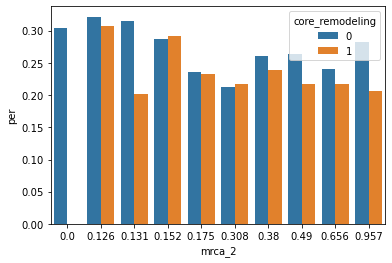

In [42]:
ot.mrca_2 = ot.mrca_2.round(3)
x, y = "mrca_2", "per"
hue = "core_remodeling"
data = ot
sns.barplot(data = data, x = x, y = y, hue = hue)